<a href="https://colab.research.google.com/github/AndresMontesDeOca/TimeSeries/blob/main/TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imortamos Librerias

In [169]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf


import warnings
warnings.filterwarnings('ignore')

# Suprimimos Notacion Cientfica
pd.set_option('display.float_format', lambda x: '%.2f' % x)


##Cargamos el Dataset

In [170]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Demanda Energia
id = '1LV2t7HpwYpxSumUywyRE1wZ2xyF1KF5I'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('DemoHoraria_v2.csv')
data = pd.read_csv('DemoHoraria_v2.csv') # Cargamos el Dataset

display(data.head())

,data_hora,Demanda_MW,Vel_viento
0,2015-10-01 02,1032.75,29.90
1,2015-10-01 03,960.61,17.30
2,2015-10-01 04,938.91,8.71
3,2015-10-01 05,943.28,7.25
4,2015-10-01 06,977.78,16.47


## Preprocesamiento

In [171]:
# Verificamos el Dataset

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   data_hora   65535 non-null  object 
 1   Demanda_MW  65535 non-null  float64
 2   Vel_viento  65535 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.5+ MB
None


- 65000 Registros
- No se observan nulos

In [172]:
# Eliminamos la Variable de Velocidad del Viento
data.drop(columns='Vel_viento', inplace=True)

# Convertimos la columna "data_hora" a tipo de datos de fecha y hora
data['data_hora'] = pd.to_datetime(data['data_hora'], format='%Y-%m-%d %H')

# Renombramos el nombre de las variables
data.rename(columns={'Demanda_MW':'Demanda', 'data_hora':'Fecha'}, inplace=True)

# Seteamos la Fecha como Index
data = data.set_index('Fecha')

display(data.head())

,Demanda
Fecha,
2015-10-01 02:00:00,1032.75
2015-10-01 03:00:00,960.61
2015-10-01 04:00:00,938.91
2015-10-01 05:00:00,943.28
2015-10-01 06:00:00,977.78


### Analizamos la Variable de estudio "Demanda"

In [173]:
# Hacemos un Describe
display(data.describe())

,Demanda
count,65535.00
mean,2968922103603471429081759744.00
std,730611400952401882395598389248.00
min,-555555.00
25%,1091.63
50%,1265.12
75%,1432.30
max,186877000000000019090986688839680.00


- Los valores absolutos son muy grandes, posibles errores?
- Hay valores Negativos, tambien posibles errores?

In [174]:
# Vemos en que fechas tenemos los errores. Cotas establecidas por el negocio [600, 2500]
display(data.query('Demanda > 2500 or Demanda < 600'))

,Demanda
Fecha,
2017-08-26 06:00:00,514.45
2017-08-26 07:00:00,388.61
2017-10-19 10:00:00,7691310000000000899886144815104.00
2017-10-19 11:00:00,186877000000000019090986688839680.00
2017-11-16 03:00:00,-555555.00
2017-11-20 03:00:00,-555555.00
2017-11-25 03:00:00,-555555.00
2018-03-20 10:00:00,2265329999999999934464.00
2018-03-20 11:00:00,43041200000000000524288.00


In [175]:
# Calculamos la Mediana general
median_demand = data['Demanda'][data['Demanda'].between(600, 2500)].median()
print('Mediana:', median_demand)

# Reemplazar valores extremos y negativos por la mediana calculada
data['Demanda'] = data['Demanda'].apply(lambda x: median_demand if x > 2500 or x < 600 else x)

# Hacemos otro Describe para verificar la correccion de los errores
display(data.describe())

Mediana: 1265.12051


,Demanda
count,65535.00
mean,1275.44
std,240.56
min,676.16
25%,1091.71
50%,1265.12
75%,1432.20
max,2237.63


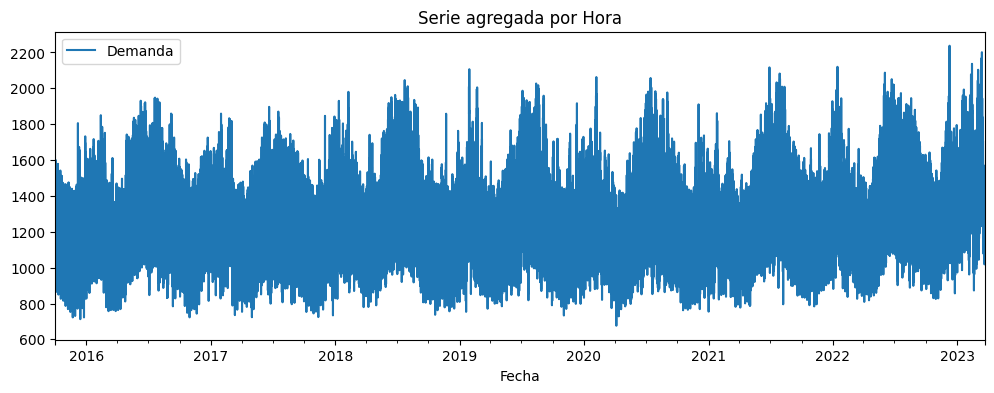

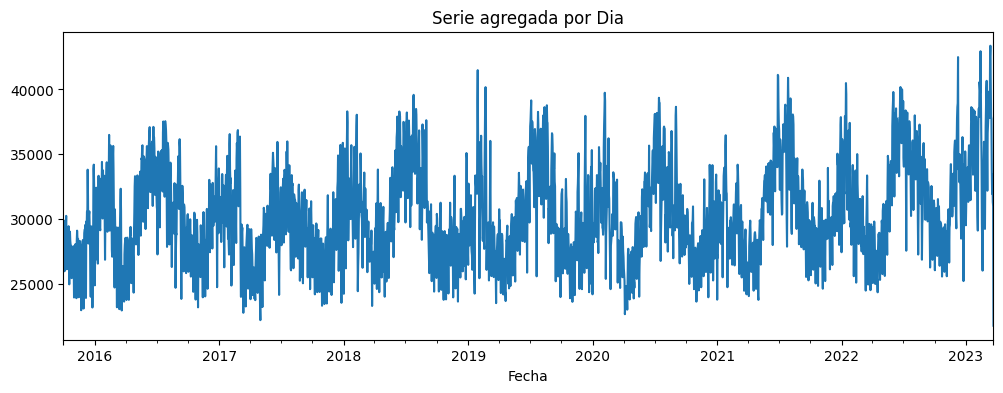

In [176]:
# Ploteamos para ver como quedaria la serie corregida
data.plot(title='Serie agregada por Hora', figsize=(12, 4))
plt.show()

# El corte por hora es muy atomizado, agregamos por dia
data_daily = data['Demanda'].resample('D').sum()
data_daily.plot(title='Serie agregada por Dia', figsize=(12, 4))
plt.show()

# Seguimos con la variable data
data = data_daily.to_frame() # Lo paso a Pandas DataFrame, sino me lo transforma a Pandas Serie

## Analisis de Estacionariedad

In [177]:
from statsmodels.tsa.stattools import adfuller

# Realizo el test analitico de Dickey-Fuller y me traigo solo el p-value
p_value = adfuller(data['Demanda'])[1]


print('P-Value del test Analitico:', p_value)

P-Value del test Analitico: 7.991704282937024e-06


- Se rechaza la H0 de No-Estacionariedad, podemos confirmar que la serie es Estacionaria

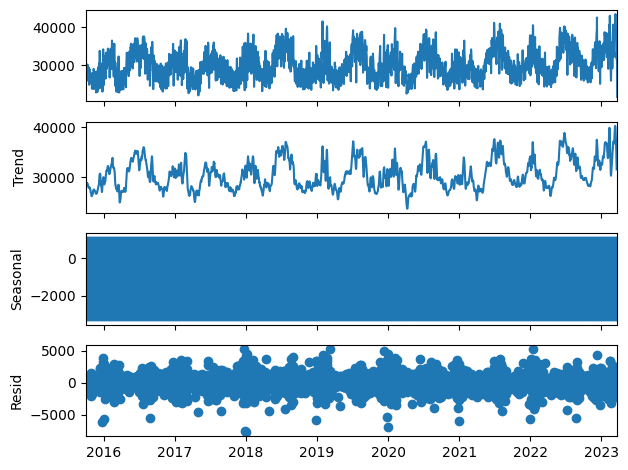

In [179]:
# Realizamos otros test graficos
# Hay que revisar el tema del periodo, esta bien usar 30/31?
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(data).plot()
plt.show()

- Sin embargo, en el analisis de las graficas, parece ser que la serie tiene estacionalidad, por ende podria llegar a ser no-estacionaria